In [1]:
%matplotlib inline
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('float_format', '{:f}'.format)

def plotPlayer(id):
    player = id
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca()
    df[df['id'] == player][['wrating', 'age']].set_index('age').sort_index().plot(ax=ax)
    df[df['id'] == player][['rating', 'age']].set_index('age').sort_index().plot(ax=ax)
    return (df[df['id'] == player][['wrating', 'tour', 'age', 'team', 'start']].set_index('age').sort_index())

In [2]:
def load_csv(system):
    df = pd.read_csv(system + '.csv', encoding="utf-8")
    df.start = pd.to_datetime(df.start, format='%d/%m/%Y')
    df.end = pd.to_datetime(df.end, format='%d/%m/%Y')
    dob = pd.read_csv('dob.csv', encoding="utf-8")
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    return df, dob

def cumulativeRating(diff, ratingName, df):
    cumsums = df[['id', 'start', diff]].groupby(['id', 'start']).sum().groupby(level=0).cumsum()
    df = df.set_index(['id', 'start'])
    df['cumur'] = cumsums
    df = df.reset_index()
    init = df[df['startglicko2rating'].notnull()].sort_values('start')[['startglicko2rating', 'id']].groupby('id').first().reset_index().rename(columns={'startglicko2rating': 'init'})
    df = pd.merge(df, init, how='left', on='id')
    df[ratingName] = df.cumur + df.init
    return df

def teamRating(rating, df):
    teameff = df.merge((df.groupby(['team', 'start']).mean()[rating] * 5).reset_index().rename(columns={rating: 'teamrating'}), on=['team', 'start'])
    teameff.teamrating = (teameff.teamrating - teameff[rating]) / 4
    return teameff

def experience(df):
    dfid2 = pd.DataFrame()
    for player in df.id.unique():
        dfid = pd.DataFrame(df[df['id'] == player].sort_values('start').tour.unique()).reset_index().rename(columns={'index': 'exp', 0: 'tour'})
        dfid['id'] = player
        dfid2 = pd.concat([dfid2, dfid])
    return pd.merge(df, dfid2, how='left', on=['id', 'tour'])
    
def dobMerge(df, dob):
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    df = df.merge(dob, how='left', on=['id'])
    df.dob = pd.to_datetime(df.dob, format='%Y/%m/%d')
    df['age'] = (df.start - df.dob) / pd.Timedelta(days=365.25)
    return df

In [3]:
df, dob = load_csv('glickoandprize')
df['diffr'] = df.endglicko2rating - df.startglicko2rating
df = cumulativeRating('diffr', 'normalRating', df)
df = teamRating('normalRating', df)
df = experience(df)
df.drop_duplicates(subset=['id', 'start'], inplace=True)

In [4]:
df, dob = load_csv('glickoandprize')
df['diffr'] = df.endglicko2rating - df.startglicko2rating
df = cumulativeRating('diffr', 'normalRating', df)
df = teamRating('normalRating', df)
df = experience(df)
df.drop_duplicates(subset=['id', 'start'], inplace=True)
df.dropna(inplace=True)
df = dobMerge(df, dob)
df.dropna(inplace=True)
df = df[(df.prizepool != 'Nan')]
df.prizepool = pd.to_numeric(df.prizepool)
df.prizeusd = pd.to_numeric(df.prizeusd.str.replace(r'\D', ''))

In [5]:
df['season'] = 'ti3'
df.loc[(df.start > pd.to_datetime('2013-08-02')) & (df.start <= pd.to_datetime('2014-07-08')), 'season'] = 'ti4'
df.loc[(df.start > pd.to_datetime('2014-07-08')) & (df.start <= pd.to_datetime('2015-07-27')), 'season'] = 'ti5'
df.loc[(df.start > pd.to_datetime('2015-07-27')) & (df.start <= pd.to_datetime('2016-08-02')), 'season'] = 'ti6'
df.loc[(df.start > pd.to_datetime('2016-08-02')) & (df.start <= pd.to_datetime('2017-08-02')), 'season'] = 'ti7'

In [6]:
df['tiprize'] = np.log(int(df[df['tour'] == 'The International 2013'].prizepool.iloc[0]))
df.loc[(df.season == 'ti4'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2014'].prizepool.iloc[0]))
df.loc[(df.season == 'ti5'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2015'].prizepool.iloc[0]))
df.loc[(df.season == 'ti6'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2016'].prizepool.iloc[0]))
df.loc[(df.season == 'ti7'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2017'].prizepool.iloc[0]))

df['wdiffr'] = (df.prizepool.apply(np.log) / df.tiprize) * df.diffr

#cumulative sum of wdiffr
cumsums = df[['id', 'start', 'wdiffr']].groupby(['id', 'start']).sum().groupby(level=0).cumsum()
df = df.set_index(['id', 'start'])
df['cumuwr'] = cumsums
df = df.reset_index()
df['perf'] = df.cumuwr + df.init

In [7]:
nt = df.groupby('id').size().reset_index()
df = df[df['id'].isin(nt[nt[0] >= 10].id.unique())]

In [8]:
df.head()

,id,start,Unnamed: 0,team,pos,tour,prizepool,place,prizeusd,startglicko2mu,...,exp,cog,name,dob,age,season,tiprize,wdiffr,cumuwr,perf
0,mushi,2012-09-08,0,orangeesports,1,WCG Asian Championship 2012,6000.000000,1,3000,1609.568030,...,0,Malaysia,Chai Yee Fung,1990-11-27,21.782341,ti3,14.871348,-1.214596,-1.214596,1445.816755
1,kyxy,2012-09-08,1,orangeesports,2,WCG Asian Championship 2012,6000.000000,1,3000,1609.568030,...,0,Malaysia,Lee Kong Yang,1991-05-26,21.289528,ti3,14.871348,-1.214596,-1.214596,1445.816755
2,xtinct,2012-09-08,3,orangeesports,4,WCG Asian Championship 2012,6000.000000,1,3000,1609.568030,...,0,Malaysia,Joel Chan Zhan Leong,1988-10-16,23.895962,ti3,14.871348,-1.214596,-1.214596,1445.816755
4,fear,2012-09-10,40,evilgeniuses,1,RaidCall Dota 2 League Season 1,10000.000000,2,3000,1739.804399,...,0,United States,Clinton Loomis,1988-02-19,24.558522,ti3,14.871348,37.003142,37.003142,1631.179011
5,jeyo,2012-09-10,41,evilgeniuses,2,RaidCall Dota 2 League Season 1,10000.000000,2,3000,1739.804399,...,0,Canada,Jio Madayag,1993-04-19,19.394935,ti3,14.871348,37.003142,37.003142,1631.179011


In [9]:
from scipy import stats
main = df.groupby('id').agg({'pos': lambda x:stats.mode(x)[0]}).reset_index()
main = main.rename(index=str, columns={'pos': 'main'})
df = df.merge(main, how='left', on=['id'])

In [10]:
ent = pd.DataFrame(df.id.unique()).reset_index().rename(columns={'index': 'entity', 0: 'id'})
df = ent.merge(df, on='id', how='left')

In [11]:
pd.set_option('float_format', '{:f}'.format)

In [12]:
def panelOLSResult(df, Y, X):
    from linearmodels import PanelOLS 
    panel_data = df.set_index(['entity', 'start']).sort_index()
    panel_data['agesq'] = panel_data.age ** 2
    panel_data['const'] = 1
    panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)
    Y = panel_data[Y]
    X = panel_data[X]
    mod = PanelOLS(Y, X, entity_effects=True)
    return mod.fit()

def feResult(res):
    fe = res.estimated_effects.reset_index().drop_duplicates().drop_duplicates(subset=['entity']).drop('time', 1)
    return ent.merge(fe, on='entity').sort_values('estimated_effects', ascending=False)

### Age and experience

In [13]:
from linearmodels import PanelOLS 
panel_data = df[['entity', 'start', 'perf', 'age', 'exp', 'pos']].set_index(['entity', 'start']).sort_index()
panel_data['agesq'] = panel_data.age ** 2
panel_data['const'] = 1
panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)

In [14]:
len(df.entity.unique())

164

In [15]:
df.tail()

,entity,id,start,Unnamed: 0,team,pos,tour,prizepool,place,prizeusd,...,cog,name,dob,age,season,tiprize,wdiffr,cumuwr,perf,main
4856,163,khezu,2017-05-25,11947,teamsecret,3,The Manila Masters,250000.000000,7-8,5000,...,Germany,Maurice Gutmann,1995-04-27,22.078029,ti7,17.025867,15.497141,41.761507,1729.831043,3
4857,163,khezu,2017-06-04,12067,teamsecret,3,EPICENTER 2017,500000.000000,3-4,40000,...,Germany,Maurice Gutmann,1995-04-27,22.105407,ti7,17.025867,13.397750,55.159257,1743.228793,3
4858,163,khezu,2017-06-14,12117,teamsecret,3,DOTA Summit 7,100000.000000,2,22500,...,Germany,Maurice Gutmann,1995-04-27,22.132786,ti7,17.025867,-3.543186,51.616072,1739.685607,3
4859,163,khezu,2017-07-21,12267,teamsecret,3,DreamLeague Season 7,175000.000000,3,30000,...,Germany,Maurice Gutmann,1995-04-27,22.234086,ti7,17.025867,-10.692056,40.924015,1728.993551,3
4860,163,khezu,2017-08-02,12342,teamsecret,3,The International 2017,24787916.000000,9-12,370319,...,Germany,Maurice Gutmann,1995-04-27,22.266940,ti7,17.025867,-2.891659,38.032356,1726.101891,3


In [16]:
df.describe()

,entity,Unnamed: 0,pos,prizepool,prizeusd,startglicko2mu,startglicko2phi,startglicko2rating,endglicko2mu,endglicko2phi,...,init,normalRating,teamrating,exp,age,tiprize,wdiffr,cumuwr,perf,main
count,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,...,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000
mean,67.187821,6918.633203,2.996091,1342571.963859,264136105.668792,1841.128250,42.634076,1734.543059,1845.487274,41.275249,...,1598.728616,1869.730939,1856.011608,26.041761,22.639532,16.463026,5.124528,174.901909,1773.630525,3.059247
std,43.980297,3386.208016,1.415299,4296199.481134,3622600182.947815,97.213157,6.576886,102.479247,95.447060,5.895585,...,94.677296,252.564205,186.150147,17.359077,2.498968,0.683499,25.210886,176.125550,171.782185,1.443371
min,0.000000,0.000000,1.000000,4410.000000,0.000000,1542.725781,28.869240,1377.868237,1514.769232,27.318820,...,1377.868237,1120.965747,1321.284974,0.000000,15.739904,14.871348,-181.977433,-268.931932,1334.374897,1.000000
25%,29.000000,4248.000000,2.000000,39000.000000,1500.000000,1778.144576,38.363352,1663.140303,1780.646087,37.368550,...,1540.350904,1698.604900,1721.643107,12.000000,20.941821,16.206471,-5.364576,37.988052,1654.939317,2.000000
50%,62.000000,7312.000000,3.000000,100000.000000,14000.000000,1847.199041,41.489108,1742.696820,1849.448321,40.319949,...,1603.306830,1841.067619,1847.128391,22.000000,22.696783,16.729469,-1.967027,148.379382,1752.318285,3.000000
75%,102.000000,9622.000000,4.000000,277668.000000,96860.000000,1913.222326,44.995443,1811.580851,1915.028650,43.742622,...,1645.784093,2005.501781,1983.505873,37.000000,24.399726,16.849042,12.563774,286.714991,1878.260351,4.000000
max,163.000000,12374.000000,5.000000,24787916.000000,102512933715.000000,2070.341655,69.914737,1952.785682,2089.277451,68.869853,...,1898.778787,2698.966417,2411.544440,83.000000,29.333333,17.025867,153.087427,653.655179,2275.313145,5.000000


In [17]:
panel_data.describe()

,perf,age,exp,pos,agesq,const,lexp
count,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000
mean,1773.630525,22.639532,26.041761,2.996091,518.791967,1.000000,3.041507
std,171.782185,2.498968,17.359077,1.415299,112.871091,0.000000,0.798491
min,1334.374897,15.739904,0.000000,1.000000,247.744583,1.000000,0.000000
25%,1654.939317,20.941821,12.000000,2.000000,438.559853,1.000000,2.564949
50%,1752.318285,22.696783,22.000000,3.000000,515.143960,1.000000,3.135494
75%,1878.260351,24.399726,37.000000,4.000000,595.346639,1.000000,3.637586
max,2275.313145,29.333333,83.000000,5.000000,860.444444,1.000000,4.430817


In [18]:
from linearmodels import PanelOLS 
carry = df[df.main == 1]
nt = carry.groupby('id').size().reset_index()
carry = carry[carry['id'].isin(nt[nt[0] >= 10].id.unique())]
carry = carry[['entity', 'start', 'perf', 'age', 'exp', 'pos']].set_index(['entity', 'start']).sort_index()
carry['agesq'] = carry.age ** 2
carry['const'] = 1
carry['lexp'] = (carry['exp'] + 1).apply(np.log)

In [19]:
Y = carry['perf']
X = carry[['age', 'agesq', 'lexp', 'const']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.3460
Estimator:,PanelOLS,R-squared (Between):,-0.4151
No. Observations:,954,R-squared (Within):,0.3460
Date:,"Sat, May 12 2018",R-squared (Overall):,-0.2046
Time:,22:26:01,Log-likelihood,-5580.6
Cov. Estimator:,Unadjusted,,
,,F-statistic:,162.60
Entities:,29,P-value,0.0000
Avg Obs:,32.897,Distribution:,"F(3,922)"
Min Obs:,11.000,,
Max Obs:,66.000,F-statistic (robust):,162.60


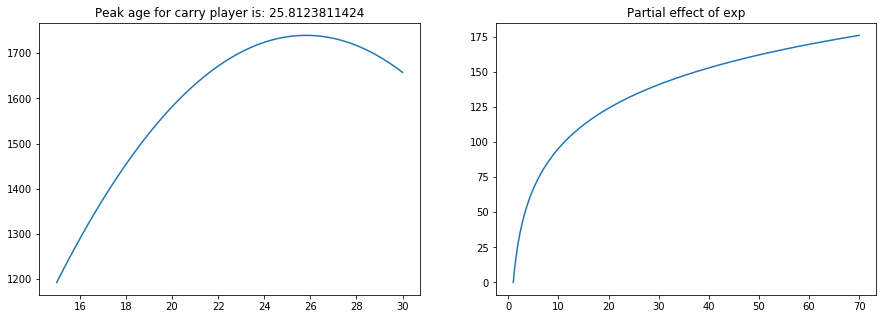

In [20]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
carryage = res.params.agesq*agex**2 + res.params.age*agex + res.params.const
lexp = res.params.lexp*np.log(lexpx)
carrypeak = -res.params.age / (2 * res.params.agesq)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, carryage)
ax[0].set_title("Peak age for carry player is: " + str(carrypeak))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of exp")
plt.show()

In [21]:
ent.merge(res.estimated_effects.reset_index(), on="entity")[['id', 'estimated_effects']].drop_duplicates('id').sort_values('estimated_effects', ascending=False)

,id,estimated_effects
544,era,353.864130
598,arteezy,353.111088
203,sylar,297.823984
943,monet,232.363992
923,ramzes666,225.339901
155,black,148.946330
722,mason,132.947150
735,burning,87.672698
494,eternalenvy,35.828839
583,bzzisperfect,30.696056


In [22]:
from linearmodels import PanelOLS 
midlaner = df[df.main == 2]
nt = midlaner.groupby('id').size().reset_index()
midlaner = midlaner[midlaner['id'].isin(nt[nt[0] >= 10].id.unique())]
midlaner = midlaner[['entity', 'start', 'perf', 'age', 'exp', 'pos']].set_index(['entity', 'start']).sort_index()
midlaner['agesq'] = midlaner.age ** 2
midlaner['const'] = 1
midlaner['lexp'] = (midlaner['exp'] + 1).apply(np.log)

In [23]:
Y = midlaner['perf']
X = midlaner[['age', 'agesq', 'lexp', 'const']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.3103
Estimator:,PanelOLS,R-squared (Between):,-0.1625
No. Observations:,920,R-squared (Within):,0.3103
Date:,"Sat, May 12 2018",R-squared (Overall):,0.0409
Time:,22:26:02,Log-likelihood,-5329.3
Cov. Estimator:,Unadjusted,,
,,F-statistic:,132.58
Entities:,33,P-value,0.0000
Avg Obs:,27.879,Distribution:,"F(3,884)"
Min Obs:,10.0000,,
Max Obs:,70.000,F-statistic (robust):,132.58


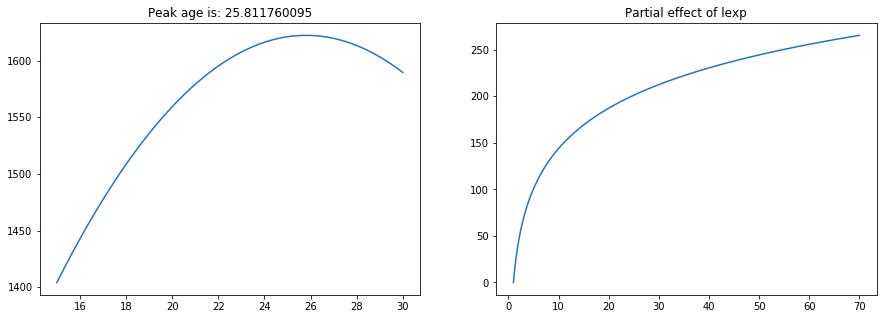

In [24]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
midlanerage = res.params.agesq*agex**2 + res.params.age*agex + res.params.const
lexp = res.params.lexp*np.log(lexpx)
midlanerpeak = -res.params.age / (2 * res.params.agesq)


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, midlanerage)
ax[0].set_title("Peak age is: " + str(midlanerpeak))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()

In [25]:
ent.merge(res.estimated_effects.reset_index(), on="entity")[['id', 'estimated_effects']].drop_duplicates('id').sort_values('estimated_effects', ascending=False)

,id,estimated_effects
637,sumail,233.184886
462,maybe,182.454084
166,fata,155.816258
723,w33,151.407474
354,super,138.840736
702,noone,113.984177
905,ana,111.220918
744,miracle,80.260588
887,fran,75.416718
855,midone,71.346074


In [26]:
from linearmodels import PanelOLS 
offlane = df[df.main == 3]
nt = offlane.groupby('id').size().reset_index()
offlane = offlane[offlane['id'].isin(nt[nt[0] >= 10].id.unique())]
offlane = offlane[['entity', 'start', 'perf', 'age', 'exp', 'pos']].set_index(['entity', 'start']).sort_index()
offlane['agesq'] = offlane.age ** 2
offlane['const'] = 1
offlane['lexp'] = (offlane['exp'] + 1).apply(np.log)

In [27]:
Y = offlane['perf']
X = offlane[['age', 'agesq', 'lexp', 'const']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.3318
Estimator:,PanelOLS,R-squared (Between):,0.1523
No. Observations:,1016,R-squared (Within):,0.3318
Date:,"Sat, May 12 2018",R-squared (Overall):,0.2081
Time:,22:26:03,Log-likelihood,-5881.5
Cov. Estimator:,Unadjusted,,
,,F-statistic:,161.71
Entities:,36,P-value,0.0000
Avg Obs:,28.222,Distribution:,"F(3,977)"
Min Obs:,11.000,,
Max Obs:,67.000,F-statistic (robust):,161.71


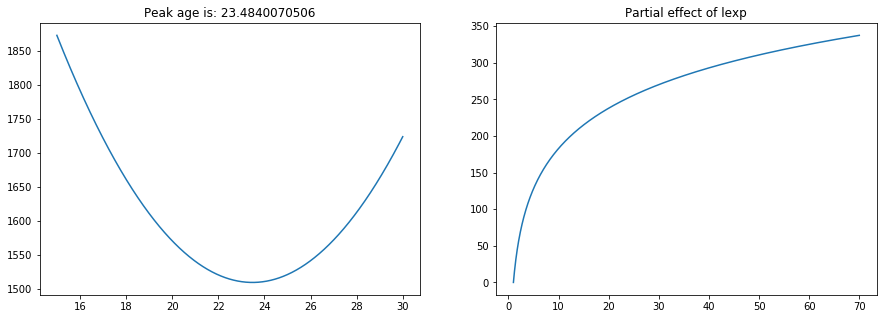

In [28]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
offlaneage = res.params.agesq*agex**2 + res.params.age*agex + res.params.const 
lexp = res.params.lexp*np.log(lexpx)
offlanepeak = -res.params.age / (2 * res.params.agesq)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, offlaneage)
ax[0].set_title("Peak age is: " + str(offlanepeak))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()

In [29]:
ent.merge(res.estimated_effects.reset_index(), on="entity")[['id', 'estimated_effects']].drop_duplicates('id').sort_values('estimated_effects', ascending=False)

,id,estimated_effects
112,xiao8,220.795358
470,trixi,213.033165
58,yao,199.870551
769,injuly,132.722867
376,universe,122.970210
891,9pasha,109.353033
501,rotk,68.731416
638,luo,66.139663
753,yoky,49.965352
676,icy,46.796096


In [30]:
from linearmodels import PanelOLS 
roaming = df[df.main == 4]
nt = roaming.groupby('id').size().reset_index()
roaming = roaming[roaming['id'].isin(nt[nt[0] >= 10].id.unique())]
roaming = roaming[['entity', 'start', 'perf', 'age', 'exp', 'pos']].set_index(['entity', 'start']).sort_index()
roaming['agesq'] = roaming.age ** 2
roaming['const'] = 1
roaming['lexp'] = (roaming['exp'] + 1).apply(np.log)

In [31]:
Y = roaming['perf']
X = roaming[['age', 'agesq', 'lexp', 'const']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.1980
Estimator:,PanelOLS,R-squared (Between):,-0.0622
No. Observations:,826,R-squared (Within):,0.1980
Date:,"Sat, May 12 2018",R-squared (Overall):,0.0780
Time:,22:26:03,Log-likelihood,-4680.9
Cov. Estimator:,Unadjusted,,
,,F-statistic:,65.247
Entities:,30,P-value,0.0000
Avg Obs:,27.533,Distribution:,"F(3,793)"
Min Obs:,10.0000,,
Max Obs:,76.000,F-statistic (robust):,65.247


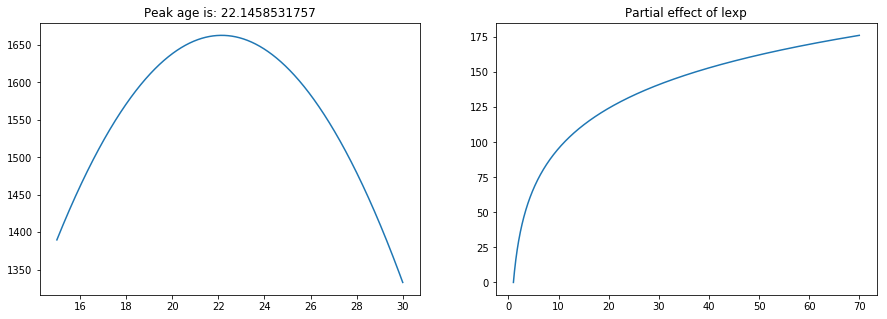

In [32]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
roamingage = res.params.agesq*agex**2 + res.params.age*agex + res.params.const
lexp = res.params.lexp*np.log(lexpx)
roamingpeak = -res.params.age / (2 * res.params.agesq)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, roamingage)
ax[0].set_title("Peak age is: " + str(roamingpeak))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()

In [33]:
ent.merge(res.estimated_effects.reset_index(), on="entity")[['id', 'estimated_effects']].drop_duplicates('id').sort_values('estimated_effects', ascending=False)

,id,estimated_effects
504,zai,344.022219
313,n0tail,281.121485
396,fy,161.155206
758,boboka,100.625334
648,alohadance,96.991447
557,lanm,96.847359
674,lil,90.952128
813,miposhka,77.099603
736,y,17.671439
244,fluffnstuff,9.960600


In [34]:
from linearmodels import PanelOLS 
support = df[df.main == 5]
nt = support.groupby('id').size().reset_index()
support = support[support['id'].isin(nt[nt[0] >= 10].id.unique())]
support = support[['entity', 'start', 'perf', 'age', 'exp', 'pos']].set_index(['entity', 'start']).sort_index()
support['agesq'] = support.age ** 2
support['const'] = 1
support['lexp'] = (support['exp'] + 1).apply(np.log)

In [35]:
Y = support['perf']
X = support[['age', 'agesq', 'lexp', 'const']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.4067
Estimator:,PanelOLS,R-squared (Between):,0.2304
No. Observations:,1145,R-squared (Within):,0.4067
Date:,"Sat, May 12 2018",R-squared (Overall):,0.2913
Time:,22:26:04,Log-likelihood,-6643.2
Cov. Estimator:,Unadjusted,,
,,F-statistic:,252.75
Entities:,36,P-value,0.0000
Avg Obs:,31.806,Distribution:,"F(3,1106)"
Min Obs:,11.000,,
Max Obs:,72.000,F-statistic (robust):,252.75


In [36]:
ent.merge(res.estimated_effects.reset_index(), on="entity")[['id', 'estimated_effects']].drop_duplicates('id').sort_values('estimated_effects', ascending=False)

,id,estimated_effects
664,ppd,223.930062
821,mmy,203.364113
420,fly,180.814207
571,fenrir,167.603527
151,ddc,108.604553
1102,victoria,94.707186
854,sansheng,75.289120
204,faith,65.634680
386,ixmike88,51.890963
1048,artstyle,41.657190


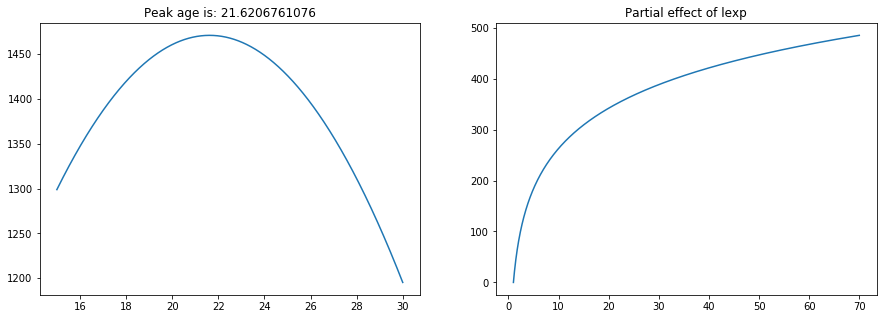

In [37]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
supportage = res.params.agesq*agex**2 + res.params.age*agex + res.params.const 
lexp = res.params.lexp*np.log(lexpx)
supportpeak = -res.params.age / (2 * res.params.agesq)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, supportage)
ax[0].set_title("Peak age is: " + str(supportpeak))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()

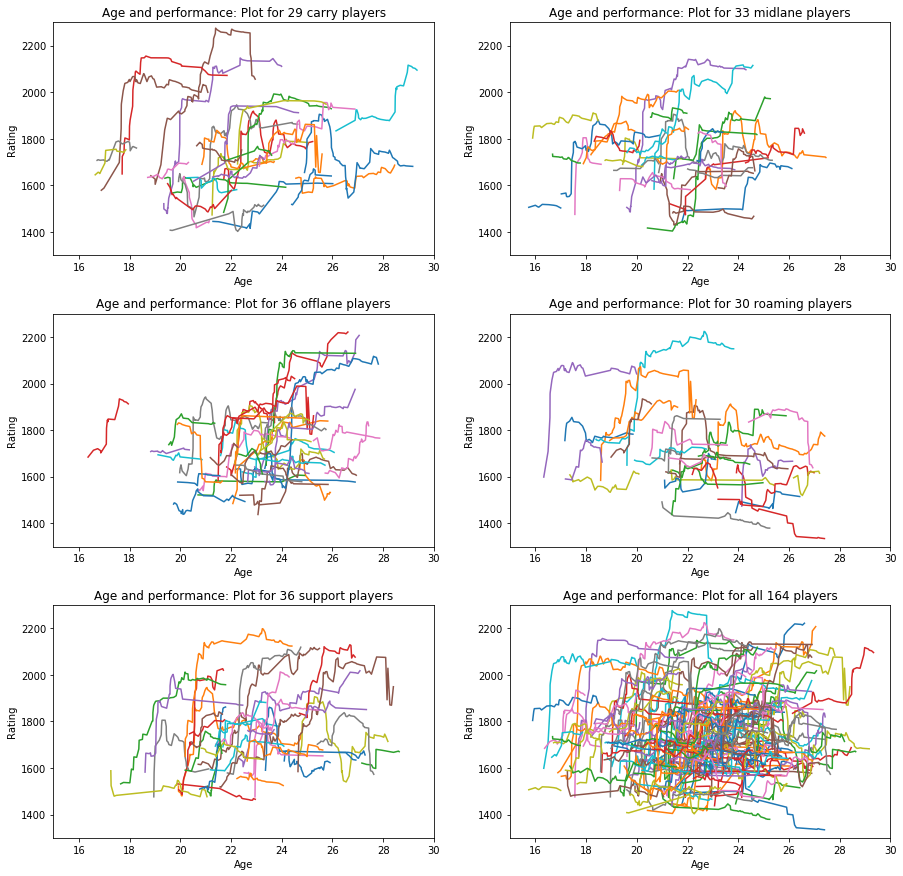

In [51]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.25)
for i, ax in enumerate(axs.reshape(-1)):
    if i == 5:
        of = df
    else:
        of = df[df.main == i+1]
        nt = of.groupby('id').size().reset_index()
        of = of[of['id'].isin(nt[nt[0] >= 10].id.unique())]
    for index, data in of.groupby('entity'):
        ax.plot(data.age, data.perf)
    ax.set_xlim(15, 30)
    ax.set_ylim(1300, 2300)
    ax.set_ylabel("Rating")
    ax.set_xlabel("Age")        
        
axs[0, 0].set_title("Age and performance: Plot for 29 carry players")
axs[0, 1].set_title("Age and performance: Plot for 33 midlane players")
axs[1, 0].set_title("Age and performance: Plot for 36 offlane players")
axs[1, 1].set_title("Age and performance: Plot for 30 roaming players")
axs[2, 0].set_title("Age and performance: Plot for 36 support players")
axs[2, 1].set_title("Age and performance: Plot for all 164 players")

plt.show()

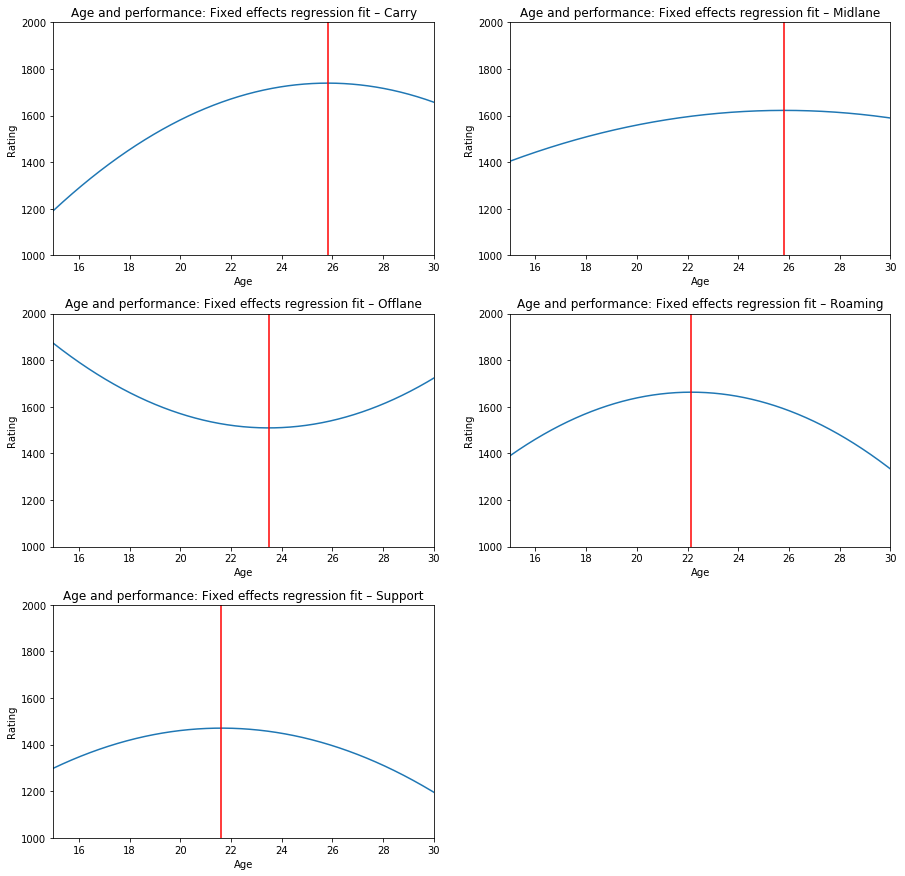

In [46]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector 

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.25)
ax[0, 0].plot(agex, carryage)
ax[0, 0].axvline(x=carrypeak, c='r')
ax[0, 0].set_title("Age and performance: Fixed effects regression fit – Carry")
ax[0, 0].set_xlim(15, 30)
ax[0, 0].set_ylim(1000, 2000)
ax[0, 0].set_ylabel("Rating")
ax[0, 0].set_xlabel("Age")
ax[0, 1].plot(agex, midlanerage)
ax[0, 1].axvline(x=midlanerpeak, c='r')
ax[0, 1].set_title("Age and performance: Fixed effects regression fit – Midlane")
ax[0, 1].set_xlim(15, 30)
ax[0, 1].set_ylim(1000, 2000)
ax[0, 1].set_ylabel("Rating")
ax[0, 1].set_xlabel("Age")
ax[1, 0].plot(agex, offlaneage)
ax[1, 0].axvline(x=offlanepeak, c='r')
ax[1, 0].set_title("Age and performance: Fixed effects regression fit – Offlane")
ax[1, 0].set_xlim(15, 30)
ax[1, 0].set_ylim(1000, 2000)
ax[1, 0].set_ylabel("Rating")
ax[1, 0].set_xlabel("Age")
ax[1, 1].plot(agex, roamingage)
ax[1, 1].axvline(x=roamingpeak, c='r')
ax[1, 1].set_title("Age and performance: Fixed effects regression fit – Roaming")
ax[1, 1].set_xlim(15, 30)
ax[1, 1].set_ylim(1000, 2000)
ax[1, 1].set_ylabel("Rating")
ax[1, 1].set_xlabel("Age")
ax[2, 0].plot(agex, supportage)
ax[2, 0].axvline(x=supportpeak, c='r')
ax[2, 0].set_title("Age and performance: Fixed effects regression fit – Support")
ax[2, 0].set_xlim(15, 30)
ax[2, 0].set_ylim(1000, 2000)
ax[2, 0].set_ylabel("Rating")
ax[2, 0].set_xlabel("Age")
ax[2, 1].set_axis_off()

plt.show()